In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, log_loss
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import os 
os.chdir("C:/Python/Cases/Glass Identification")

In [2]:
df = pd.read_csv("Glass.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows_float_processed
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows_float_processed
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows_float_processed
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows_float_processed
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows_float_processed


In [3]:
X = df.drop('Type', axis=1)
y = df['Type']

In [4]:
le = LabelEncoder()
le_y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.3, 
                                                    random_state=24,stratify=le_y)

In [5]:
X.shape, y.shape

((214, 9), (214,))

In [6]:
ohe = OneHotEncoder(sparse_output=False)
y_trn_ohe = ohe.fit_transform( y_train.reshape(-1,1) )
y_trn_ohe.shape

(149, 6)

In [7]:
scaler = MinMaxScaler()
X_scl_trn = scaler.fit_transform(X_train) 
X_scl_tst = scaler.transform(X_test) 

In [8]:
X_torch = torch.from_numpy(X_scl_trn)
y_torch = torch.from_numpy(y_trn_ohe)
print(X_torch.size())
print(y_torch.size())

torch.Size([149, 9])
torch.Size([149, 6])


In [9]:
type(X_torch)

torch.Tensor

In [10]:
X_scl_trn.shape

(149, 9)

### Model Definition

In [12]:
torch.manual_seed(24)
model = nn.Sequential(nn.Linear(in_features=X_scl_trn.shape[1], out_features=7),
                      nn.Tanh(),
                      nn.Linear(in_features=7, out_features=6)
                     )

In [13]:
summary(model, (1,X_scl_trn.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 7]              70
              Tanh-2                 [-1, 1, 7]               0
            Linear-3                 [-1, 1, 6]              48
Total params: 118
Trainable params: 118
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.1)
optimizer

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    fused: None
    initial_accumulator_value: 0
    lr: 0.1
    lr_decay: 0
    maximize: False
    weight_decay: 0
)

Initialized Weights

In [16]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1763, -0.0833, -0.2833,  0.0205,  0.3107, -0.1487, -0.1085,  0.2607,
         -0.0464],
        [-0.1273, -0.0671,  0.0122, -0.2716, -0.0953,  0.3232, -0.0715,  0.3036,
         -0.1301],
        [-0.1341, -0.0994, -0.2980, -0.2008,  0.2015, -0.2501,  0.1139,  0.3136,
         -0.0424],
        [ 0.1458,  0.1557, -0.2379, -0.1285, -0.1044,  0.3217, -0.2975,  0.2018,
          0.3131],
        [ 0.2636,  0.1421,  0.1484, -0.0178,  0.1677,  0.3038, -0.1072,  0.3221,
          0.0530],
        [-0.2338, -0.2392,  0.1176, -0.0470, -0.1468,  0.1688, -0.1758, -0.1593,
          0.0623],
        [-0.0602, -0.2813, -0.1001, -0.1171, -0.1421,  0.2595, -0.0506, -0.2036,
          0.0988]], requires_grad=True)
Parameter containing:
tensor([ 0.0574, -0.2531, -0.3192,  0.2522, -0.3087,  0.3309,  0.1861],
       requires_grad=True)
Parameter containing:
tensor([[ 0.3154, -0.3289,  0.1390, -0.3669,  0.1076,  0.1723,  0.0554],
        [-0.1353, -0.1402, -0.0312,  0.35

Generating predictions with default weights

In [18]:
y_pred = model(X_torch.float())
y_pred[:3]

tensor([[ 0.3251,  0.3862,  0.3910,  0.1139,  0.0065, -0.4131],
        [ 0.2183,  0.5136,  0.4549, -0.1099, -0.0219, -0.5384],
        [ 0.3510,  0.3600,  0.4233,  0.0296,  0.0262, -0.4330]],
       grad_fn=<SliceBackward0>)

In [19]:
print(y_torch.shape)

torch.Size([149, 6])


In [20]:
#y_torch = y_torch.unsqueeze(1)
print(y_torch.shape)
print(y_pred.shape)

torch.Size([149, 6])
torch.Size([149, 6])


### Initial Log Loss

In [22]:
loss = criterion(y_pred, y_torch.float())
loss

tensor(1.7068, grad_fn=<DivBackward1>)

In [23]:
for epoch in np.arange(0,10000):
       # Forward pass: Compute predicted y by passing x to the model
       y_pred_prob = model(X_torch.float())

       # Compute and print loss
       loss = criterion(y_pred_prob, y_torch.float())
       if epoch%1000 == 0:
          print('epoch: ', epoch+1,' loss: ', loss.item())

       # Zero gradients, perform a backward pass, and update the weights.
       optimizer.zero_grad()

       # perform a backward pass (backpropagation)
       loss.backward()

       # Update the parameters
       optimizer.step()
#print('epoch: ', epoch+1,' loss: ', loss.item())

epoch:  1  loss:  1.7068088054656982
epoch:  1001  loss:  0.49898990988731384
epoch:  2001  loss:  0.3872394561767578
epoch:  3001  loss:  0.3361450433731079
epoch:  4001  loss:  0.309278666973114
epoch:  5001  loss:  0.2932899594306946
epoch:  6001  loss:  0.28161922097206116
epoch:  7001  loss:  0.27161771059036255
epoch:  8001  loss:  0.2622207999229431
epoch:  9001  loss:  0.253280907869339


### Training Set Log Loss

In [25]:
loss

tensor(0.2445, grad_fn=<DivBackward1>)

In [26]:
X_torch_test = torch.from_numpy(X_scl_tst)
type(X_torch_test)

torch.Tensor

In [27]:
y_wt_sum = model(X_torch_test.float()) 
softmax = nn.Softmax(dim=1)
y_pred_prob = softmax(y_wt_sum)
y_pred_prob[:3]

tensor([[9.9612e-01, 2.4099e-04, 2.6743e-07, 3.3167e-11, 2.6418e-14, 3.6399e-03],
        [3.3009e-19, 1.2697e-07, 7.9349e-15, 1.0000e+00, 5.9506e-11, 8.2447e-27],
        [1.9250e-02, 9.7319e-01, 1.1530e-08, 1.1935e-03, 3.0091e-04, 6.0639e-03]],
       grad_fn=<SliceBackward0>)

`detach().numpy()` converts `torch.Tensor` into `numpy` object

In [29]:
y_pred_prob = y_pred_prob.detach().numpy()
y_pred_prob.shape

(65, 6)

In [30]:
y_pred = np.argmax(y_pred_prob, axis=1 )
y_pred.shape

(65,)

### Test Set Accuracy Score

In [32]:
print(accuracy_score(y_test,y_pred))

0.7230769230769231


### Test Set Log Loss

In [34]:
log_loss(y_test, y_pred_prob)

1.5422503307060171

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [36]:
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

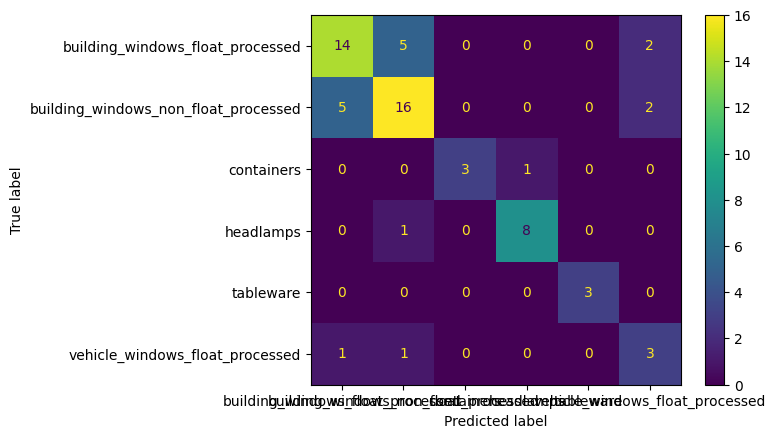

In [66]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = list(le.classes_))
disp.plot()
plt.show()